In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from package import euklid_regressor as eu
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import optimizers
import tensorflow as tf

In [2]:
yahoo_df = pd.read_csv('../data/NSQ.csv')

In [3]:
yahoo_df =yahoo_df[["Close",'SO',
                       'RSI_1', 'RSI_2', 'RSI_3', 'RSI_14', '1 Day ROI', '2 Day ROI',
                       '3 Day ROI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
                     "Previous_differenced",
                    "Differenced"]]
price = yahoo_df['Differenced'] 
close = yahoo_df['Close']
yahoo_df

Close          SO      RSI_1      RSI_2      RSI_3     RSI_14  \
0      1791.00   71.689895  21.862764  39.404226  47.783316  52.064839   
1      1824.00   77.439024  49.007054  50.908448  54.563943  53.590307   
2      1774.00   63.103803  23.874383  35.563467  43.224632  50.957746   
3      1823.00   73.175745  62.035182  55.348283  55.349391  53.363270   
4      1866.50   80.837004  79.913226  68.306695  64.358818  55.442106   
...        ...         ...        ...        ...        ...        ...   
5285  14654.00  100.000000  97.741922  91.613859  85.112742  57.846042   
5286  14447.00   87.130867  53.329366  64.595899  66.791862  54.672003   
5287  14763.75  100.000000  80.477412  78.887258  76.925560  58.413145   
5288  14755.75   99.534410  78.180231  77.699029  76.143093  58.282974   
5289  14985.25  100.000000  91.727842  86.469111  82.825256  60.957224   

      1 Day ROI  2 Day ROI  3 Day ROI  MACD_12_26_9  MACDh_12_26_9  \
0     -0.015393  -0.083184  -0.083184     14.845864      48.764418   
1      0.018425   0.002749  -0.066291     19.312162      42.584572   
2     -0.027412  -0.009492  -0.024739     18.602712      33.500098   
3      0.027621  -0.000548   0.017867     21.743711      29.312877   
4      0.023862   0.052142   0.023300     27.426901      27.996854   
...         ...        ...        ...           ...            ...   
5285   0.019728   0.039637   0.038425    -62.553224     155.357918   
5286  -0.014126   0.005323   0.024951    -21.673629     156.990010   
5287   0.021925   0.007489   0.027365     35.869343     171.626385   
5288  -0.000542   0.021371   0.006943     79.905923     172.530373   
5289   0.015553   0.015003   0.037257    131.804602     179.543241   

      MACDs_12_26_9  Previous_differenced  Differenced  
0        -33.918554             -0.068851    -0.015393  
1        -23.272411             -0.015393     0.018425  
2        -14.897386              0.018425    -0.027412  
3         -7.569167             -0.027412     0.027621  
4         -0.569953              0.027621     0.023862  
...             ...                   ...          ...  
5285    -217.911141              0.019524     0.019728  
5286    -178.663639              0.019728    -0.014126  
5287    -135.757043             -0.014126     0.021925  
5288     -92.624449              0.021925    -0.000542  
5289     -47.738639             -0.000542     0.015553  

[5290 rows x 14 columns]

In [4]:
# convert series to supervised learning
values = yahoo_df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
values

array([[ 1.7910000e+03,  7.1689896e+01,  2.1862764e+01, ...,
        -3.3918552e+01, -6.8850778e-02, -1.5393073e-02],
       [ 1.8240000e+03,  7.7439026e+01,  4.9007053e+01, ...,
        -2.3272411e+01, -1.5393073e-02,  1.8425461e-02],
       [ 1.7740000e+03,  6.3103802e+01,  2.3874382e+01, ...,
        -1.4897387e+01,  1.8425461e-02, -2.7412280e-02],
       ...,
       [ 1.4763750e+04,  1.0000000e+02,  8.0477409e+01, ...,
        -1.3575705e+02, -1.4125836e-02,  2.1924967e-02],
       [ 1.4755750e+04,  9.9534409e+01,  7.8180229e+01, ...,
        -9.2624451e+01,  2.1924967e-02, -5.4186775e-04],
       [ 1.4985250e+04,  1.0000000e+02,  9.1727844e+01, ...,
        -4.7738640e+01, -5.4186775e-04,  1.5553259e-02]], dtype=float32)

# Train, test, val

In [5]:
X =  yahoo_df[[  'SO',
                       'RSI_1', 'RSI_2', 'RSI_3', 'RSI_14', '1 Day ROI', '2 Day ROI',
                       '3 Day ROI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
                     "Previous_differenced",
                    ]]

y = yahoo_df["Differenced"]

In [6]:
# Split in 80/20 the dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,shuffle=False)
close_train, close_test = train_test_split(close,test_size = 0.20, shuffle=False)

close_train, close_test = list(close_train), list(close_test) 

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [8]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

y_train = y_train.values
y_test = y_test.values
print(X_train.shape)
print(y_train.shape)

(4232, 1, 12)
(4232,)


# LSTM

In [9]:
model = Sequential()
model.add(LSTM(75, return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(40))
model.add(Dense(1))

In [10]:
# Set early stopping monitor so the model stops training when it won't improve anymore
esm = EarlyStopping(monitor = 'loss', patience = 70)
# Set the optimizer
opt = tf.optimizers.SGD(learning_rate = 0.001)
#design network
batch_size = int(round(X_train.shape[0]*0.1))
# fit network
model.compile(loss='mae', optimizer=opt)
history = model.fit(X_train, y_train, epochs=2000, batch_size= batch_size, verbose=1,
    shuffle=False, validation_split=0.10)

Epoch 1/2000
10/10 [==============================] - 2s 94ms/step - loss: 0.3104 - val_loss: 0.2592
Epoch 2/2000
10/10 [==============================] - 1s 55ms/step - loss: 0.2786 - val_loss: 0.2266
Epoch 3/2000
10/10 [==============================] - 1s 55ms/step - loss: 0.2608 - val_loss: 0.1954
Epoch 4/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.2440 - val_loss: 0.1748
Epoch 5/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.2344 - val_loss: 0.1600
Epoch 6/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.2341 - val_loss: 0.1526
Epoch 7/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.2320 - val_loss: 0.1409
Epoch 8/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.2169 - val_loss: 0.1383
Epoch 9/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.2183 - val_loss: 0.1350
Epoch 10/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.2146 - val_loss: 0.1

10/10 [==============================] - 0s 5ms/step - loss: 0.1018 - val_loss: 0.0664
Epoch 83/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.1025 - val_loss: 0.0630
Epoch 84/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.1005 - val_loss: 0.0616
Epoch 85/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0997 - val_loss: 0.0632
Epoch 86/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0966 - val_loss: 0.0609
Epoch 87/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0964 - val_loss: 0.0613
Epoch 88/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0986 - val_loss: 0.0628
Epoch 89/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0960 - val_loss: 0.0630
Epoch 90/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0951 - val_loss: 0.0632
Epoch 91/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0947 - val_loss: 0.0598
Epoc

10/10 [==============================] - 0s 5ms/step - loss: 0.0437 - val_loss: 0.0258
Epoch 163/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0435 - val_loss: 0.0252
Epoch 164/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0429 - val_loss: 0.0251
Epoch 165/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0433 - val_loss: 0.0247
Epoch 166/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0422 - val_loss: 0.0248
Epoch 167/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0413 - val_loss: 0.0248
Epoch 168/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0405 - val_loss: 0.0243
Epoch 169/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0413 - val_loss: 0.0243
Epoch 170/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0393 - val_loss: 0.0240
Epoch 171/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0400 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0247 - val_loss: 0.0166
Epoch 243/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0247 - val_loss: 0.0167
Epoch 244/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0246 - val_loss: 0.0165
Epoch 245/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0248 - val_loss: 0.0168
Epoch 246/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0241 - val_loss: 0.0167
Epoch 247/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0245 - val_loss: 0.0162
Epoch 248/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0243 - val_loss: 0.0163
Epoch 249/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0243 - val_loss: 0.0161
Epoch 250/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0248 - val_loss: 0.0165
Epoch 251/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0240 - val_loss: 0.

10/10 [==============================] - 0s 5ms/step - loss: 0.0199 - val_loss: 0.0125
Epoch 323/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0199 - val_loss: 0.0122
Epoch 324/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0194 - val_loss: 0.0125
Epoch 325/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0201 - val_loss: 0.0125
Epoch 326/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0191 - val_loss: 0.0120
Epoch 327/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0190 - val_loss: 0.0124
Epoch 328/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0199 - val_loss: 0.0120
Epoch 329/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0193 - val_loss: 0.0124
Epoch 330/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0190 - val_loss: 0.0125
Epoch 331/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0197 - val_loss: 0.

10/10 [==============================] - 0s 6ms/step - loss: 0.0176 - val_loss: 0.0100
Epoch 403/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0165 - val_loss: 0.0096
Epoch 404/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0165 - val_loss: 0.0103
Epoch 405/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0173 - val_loss: 0.0101
Epoch 406/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0168 - val_loss: 0.0096
Epoch 407/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0094
Epoch 408/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0163 - val_loss: 0.0102
Epoch 409/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0168 - val_loss: 0.0097
Epoch 410/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0165 - val_loss: 0.0097
Epoch 411/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0143 - val_loss: 0.0080
Epoch 483/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0144 - val_loss: 0.0083
Epoch 484/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0144 - val_loss: 0.0084
Epoch 485/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0150 - val_loss: 0.0079
Epoch 486/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0147 - val_loss: 0.0082
Epoch 487/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0151 - val_loss: 0.0081
Epoch 488/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0146 - val_loss: 0.0078
Epoch 489/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0083
Epoch 490/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0081
Epoch 491/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0147 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0075
Epoch 563/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0070
Epoch 564/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0138 - val_loss: 0.0072
Epoch 565/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0136 - val_loss: 0.0071
Epoch 566/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0138 - val_loss: 0.0073
Epoch 567/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0067
Epoch 568/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0071
Epoch 569/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0136 - val_loss: 0.0074
Epoch 570/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0073
Epoch 571/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0065
Epoch 643/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0126 - val_loss: 0.0062
Epoch 644/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0064
Epoch 645/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0064
Epoch 646/2000
10/10 [==============================] - 0s 8ms/step - loss: 0.0124 - val_loss: 0.0068
Epoch 647/2000
10/10 [==============================] - 0s 8ms/step - loss: 0.0124 - val_loss: 0.0066
Epoch 648/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0127 - val_loss: 0.0063
Epoch 649/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0069
Epoch 650/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0120 - val_loss: 0.0064
Epoch 651/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.

10/10 [==============================] - 0s 5ms/step - loss: 0.0116 - val_loss: 0.0061
Epoch 723/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0115 - val_loss: 0.0060
Epoch 724/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0119 - val_loss: 0.0062
Epoch 725/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0062
Epoch 726/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0059
Epoch 727/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0061
Epoch 728/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0063
Epoch 729/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0066
Epoch 730/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0060
Epoch 731/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.

10/10 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0060
Epoch 803/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0060
Epoch 804/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0059
Epoch 805/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0065
Epoch 806/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0055
Epoch 807/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0058
Epoch 808/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0062
Epoch 809/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0060
Epoch 810/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0056
Epoch 811/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0052
Epoch 883/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0059
Epoch 884/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0053
Epoch 885/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0060
Epoch 886/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0055
Epoch 887/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0059
Epoch 888/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0053
Epoch 889/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0060
Epoch 890/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0055
Epoch 891/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.

10/10 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0059
Epoch 963/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0051
Epoch 964/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0059
Epoch 965/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0053
Epoch 966/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0058
Epoch 967/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0051
Epoch 968/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0059
Epoch 969/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0055
Epoch 970/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0053
Epoch 971/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0051
Epoch 1043/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0058
Epoch 1044/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0056
Epoch 1045/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0050
Epoch 1046/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0051
Epoch 1047/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0103 - val_loss: 0.0059
Epoch 1048/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0056
Epoch 1049/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0051
Epoch 1050/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0054
Epoch 1051/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0103 - val

10/10 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0061
Epoch 1122/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0052
Epoch 1123/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0058
Epoch 1124/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0057
Epoch 1125/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0050
Epoch 1126/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0058
Epoch 1127/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0052
Epoch 1128/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0052
Epoch 1129/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0051
Epoch 1130/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0098 - val

10/10 [==============================] - 0s 5ms/step - loss: 0.0096 - val_loss: 0.0048
Epoch 1201/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0096 - val_loss: 0.0058
Epoch 1202/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.0049
Epoch 1203/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0049
Epoch 1204/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0098 - val_loss: 0.0057
Epoch 1205/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.0049
Epoch 1206/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0098 - val_loss: 0.0058
Epoch 1207/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 1208/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.0049
Epoch 1209/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0095 - val

10/10 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0053
Epoch 1280/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0096 - val_loss: 0.0047
Epoch 1281/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0048
Epoch 1282/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0056
Epoch 1283/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0047
Epoch 1284/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 1285/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 1286/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0047
Epoch 1287/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 1288/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0096 - val

10/10 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0046
Epoch 1359/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0048
Epoch 1360/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0052
Epoch 1361/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0048
Epoch 1362/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0055
Epoch 1363/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0049
Epoch 1364/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 1365/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 1366/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0047
Epoch 1367/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0094 - val

10/10 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 1438/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0048
Epoch 1439/2000
10/10 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 1440/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0048
Epoch 1441/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0048
Epoch 1442/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0046
Epoch 1443/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 1444/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0047
Epoch 1445/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0049
Epoch 1446/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0092 - val

10/10 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.0052
Epoch 1517/2000
10/10 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.0045
Epoch 1518/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0045
Epoch 1519/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 1520/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 0.0046
Epoch 1521/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 1522/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 1523/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0046
Epoch 1524/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0053
Epoch 1525/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0091 - val

10/10 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 1596/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 1597/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0046
Epoch 1598/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0046
Epoch 1599/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 1600/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0046
Epoch 1601/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 1602/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0045
Epoch 1603/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 1604/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0089 - val

10/10 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0049
Epoch 1675/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0053
Epoch 1676/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0045
Epoch 1677/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0048
Epoch 1678/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0048
Epoch 1679/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0045
Epoch 1680/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0049
Epoch 1681/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 1682/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0044
Epoch 1683/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0089 - val

10/10 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0045
Epoch 1754/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0046
Epoch 1755/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 1756/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0048
Epoch 1757/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0047
Epoch 1758/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0050
Epoch 1759/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0043
Epoch 1760/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0051
Epoch 1761/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0044
Epoch 1762/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0088 - val

10/10 [==============================] - 0s 7ms/step - loss: 0.0086 - val_loss: 0.0044
Epoch 1833/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 1834/2000
10/10 [==============================] - 0s 8ms/step - loss: 0.0088 - val_loss: 0.0045
Epoch 1835/2000
10/10 [==============================] - 0s 8ms/step - loss: 0.0087 - val_loss: 0.0047
Epoch 1836/2000
10/10 [==============================] - 0s 8ms/step - loss: 0.0087 - val_loss: 0.0053
Epoch 1837/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0088 - val_loss: 0.0046
Epoch 1838/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0087 - val_loss: 0.0050
Epoch 1839/2000
10/10 [==============================] - 0s 8ms/step - loss: 0.0087 - val_loss: 0.0045
Epoch 1840/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0086 - val_loss: 0.0049
Epoch 1841/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0087 - val

10/10 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0043
Epoch 1912/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0047
Epoch 1913/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0044
Epoch 1914/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0046
Epoch 1915/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0048
Epoch 1916/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0042
Epoch 1917/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0051
Epoch 1918/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0043
Epoch 1919/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.0046
Epoch 1920/2000
10/10 [==============================] - 0s 7ms/step - loss: 0.0087 - val

10/10 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0043
Epoch 1991/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0047
Epoch 1992/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0042
Epoch 1993/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0044
Epoch 1994/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0050
Epoch 1995/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0042
Epoch 1996/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 1997/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0043
Epoch 1998/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0050
Epoch 1999/2000
10/10 [==============================] - 0s 6ms/step - loss: 0.0087 - val

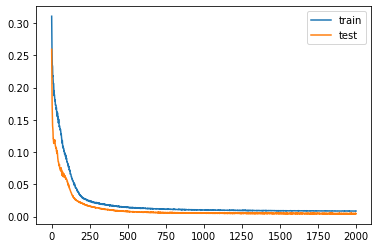

In [11]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Prediction 

In [12]:
predict = model.predict(X_test)
predict = [float(predict[i]) for i in range(len(predict))]
pred = eu.scale_back_pct(predict, close_test)
updown_pred = eu.ud_pred(pred, close_test)

In [13]:
df = pd.DataFrame(updown_pred)
df["Close"] = list(close_test)
df["updown_pred"] = df.iloc[:,0]
df["updown_actual"] = eu.ud(close_test)
df["Scaled_pred"] = pred
df["Pred"] = predict
df = df.iloc[:,1:] 
acc = (df["updown_pred"] == df["updown_actual"]).sum()/df.shape[0]
print('Model Accuracy: ', acc)


Model Accuracy:  0.6247637051039697


In [14]:
df

Close  updown_pred  updown_actual   Scaled_pred      Pred
0      6823.75            1              1   6823.750000 -0.000521
1      6813.00            0              0   6805.745461 -0.002639
2      6845.75            0              1   6806.429642 -0.000964
3      6931.00            0              1   6834.255428 -0.001679
4      6965.75            0              1   6911.383191 -0.002830
...        ...          ...            ...           ...       ...
1053  14654.00            1              1  22248.415971  0.548201
1054  14447.00            1              0  17915.897613  0.222594
1055  14763.75            1              1  19179.502692  0.327577
1056  14755.75            1              0  18006.383735  0.219635
1057  14985.25            0              1  14598.890559 -0.010630

[1058 rows x 5 columns]

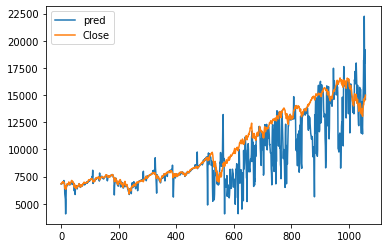

In [15]:
plt.plot(df['Scaled_pred'], label='pred')
plt.plot(df["Close"], label='Close')
plt.legend()
plt.show()

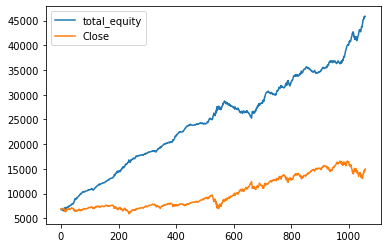

In [16]:
df_equity = pd.DataFrame()
df_equity["long_equity"] = eu.long_equity(df["updown_pred"], df["Close"])
df_equity["short_equity"] = eu.short_equity(df["updown_pred"], df["Close"])
df_equity["total_equity"] = eu.total_equity(df["updown_pred"], df["Close"])
df_equity["total_equity"].cumsum().plot()
df["Close"].plot()
plt.legend()

# Save Accuracies

In [17]:
df_prediction = pd.read_csv("../data/model_accuracy_nsq.csv", index_col = False)
df_prediction

Unnamed: 0  RF_pred  RF_accuracy   RF_prob  SVC_pred  SVC_accuracy  \
0              0        1     0.523629  0.657543         1      0.558601   
1              1        0     0.523629  0.324182         1      0.558601   
2              2        0     0.523629  0.496864         1      0.558601   
3              3        1     0.523629  0.574333         1      0.558601   
4              4        0     0.523629  0.421569         1      0.558601   
...          ...      ...          ...       ...       ...           ...   
1053        1053        1     0.523629  0.679418         1      0.558601   
1054        1054        1     0.523629  0.555801         1      0.558601   
1055        1055        1     0.523629  0.573323         1      0.558601   
1056        1056        1     0.523629  0.719503         1      0.558601   
1057        1057        1     0.523629  0.531916         1      0.558601   

      SVC_prob  XGB_pred  XGB_accuracy  XGB_prob  ANN_pred  ANN_accuracy  \
0     0.544082         1      0.533081  0.536098         0      0.441399   
1     0.544076         0      0.533081  0.390463         0      0.441399   
2     0.545460         1      0.533081  0.552227         0      0.441399   
3     0.545009         1      0.533081  0.596263         0      0.441399   
4     0.543872         0      0.533081  0.483318         0      0.441399   
...        ...       ...           ...       ...       ...           ...   
1053  0.539406         1      0.533081  0.598255         0      0.441399   
1054  0.537904         1      0.533081  0.567730         0      0.441399   
1055  0.540966         1      0.533081  0.561254         0      0.441399   
1056  0.536726         1      0.533081  0.590790         0      0.441399   
1057  0.541307         1      0.533081  0.569102         0      0.441399   

      ANN_prob  LGBM_pred  LGBM_accuracy  LGBM_prob  y  kNN_pred  \
0     0.464561          1       0.529301   0.532322  0         0   
1     0.464505          1       0.529301   0.518503  1         0   
2     0.464505          1       0.529301   0.515129  1         1   
3     0.464505          1       0.529301   0.531008  1         0   
4     0.464505          1       0.529301   0.529314  0         0   
...        ...        ...            ...        ... ..       ...   
1053  0.464011          1       0.529301   0.510938  0         1   
1054  0.464421          1       0.529301   0.511045  1         0   
1055  0.463568          1       0.529301   0.509250  0         0   
1056  0.464013          1       0.529301   0.510938  1         1   
1057  0.462834          1       0.529301   0.511825  1         1   

      kNN_accuracy  kNN_prob  
0         0.482987       0.5  
1         0.482987       0.5  
2         0.482987       1.0  
3         0.482987       0.5  
4         0.482987       0.0  
...            ...       ...  
1053      0.482987       1.0  
1054      0.482987       0.5  
1055      0.482987       0.0  
1056      0.482987       1.0  
1057      0.482987       1.0  

[1058 rows x 20 columns]

In [18]:
df_prediction["LSTM_price_accuracy"] = [acc for x in range(len(df_prediction))]


In [19]:
df_prediction.to_csv("../data/model_accuracy_nsq.csv")